# Analysis and figures for McKinnon and Simpson, "How unexpected was the 2021 Pacific Northwest heatwave?", GRL, 2022.

In [2]:
%load_ext autoreload
%autoreload 2

from helpful_utilities.general import lowpass_butter
from helpful_utilities.ncutils import lon_to_180
from record_breaking_heat import utils as heat_utils

import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats, signal
from glob import glob
import os
from time import time
from datetime import timedelta, datetime
from statsmodels.regression.quantile_regression import QuantReg
from subprocess import check_call

from scipy.stats import genextreme as gev
from scipy.stats import kstest

import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import colors

%matplotlib inline

In [30]:
# Define directories, parameters, etc.
figdir = '/home/kmckinnon/record_breaking_heat/figs'
procdir = '/home/kmckinnon/record_breaking_heat/data/proc'

# Parameters for selecting GHCND data
start_year_GHCND = 1900
end_year_GHCND = 2021
GHCND_var_names = (['TMIN', 'TMAX'])
missing_data_cutoff = 0.2  # max fraction of missing data during period

# Parameters for selecting Env Canada data
start_year_EC = 1925
end_year_EC = 2021

# Parameters for selecting ISD data
# Canadian ISD data starts in 1977, American data starts in 1973
# Only use stations that start no later than 1977, but keep data back to 1973 if available
start_year_ISD_min = 1973
start_year_ISD_max = 1977
end_year_ISD = 2021

# Define season to analyze
doy_start = 166  # June 15 (non leap)
doy_end = 196  # July 15 (non leap)

# Define domain for Pacific Northwest
lats_PNW = 43, 57
lons_PNW = -123, -115
lons_PNW_360 = lons_PNW[0] + 360, lons_PNW[1] + 360

# Number of harmonics to fit for the seasonal cycle
nseasonal = 5
# Number of harmonics that can change linearly with GMTA
ninteract = 1

# Dates that span peak heat at each station
heat_date_range = slice('2021-06-27', '2021-07-01')

# Consider heatwave based on TMAX (can change to TMIN)
variable_to_use = 'TMAX'
cesm_var = 'TREFHTMX'  # CESM name

# For CESM2 analysis: use smbb forcing
forcing = 'smbb'
cesm_dir = '/home/data/projects/record_heat/cesm2_le'

fontsize = 16
sec_per_day = 3600*24

# Load in and process station data

Pre-process to remove leap days, calculate anomalies from trend

## GHCND

GHCND data is pre-processed into netcdf files using the get_ghcnd.py script in the scripts folder. As written, the script pulls all data in the US and Canada that at least spans 1900-2021.

In [7]:
ghcnd_dir = '/home/data/GHCND'
f_station_list = '%s/ghcnd-stations.txt' % ghcnd_dir
f_inventory = '%s/ghcnd-inventory.txt' % ghcnd_dir

datadir_ghcnd = '/home/kmckinnon/record_breaking_heat/data/%04i-%04i' % (start_year_GHCND, end_year_GHCND)

inventory_dict = heat_utils.get_ghcnd_inventory_dict(GHCND_var_names, f_inventory)
station_list, lats, lons = heat_utils.get_ghcnd_station_list(GHCND_var_names, inventory_dict, 
                                                             lats_PNW, lons_PNW, 
                                                             start_year_GHCND, end_year_GHCND)

ds_ghcnd = heat_utils.get_ghcnd_ds(station_list, GHCND_var_names, datadir_ghcnd, 
                                   start_year_GHCND, end_year_GHCND)
# Remove Feb 29
ds_ghcnd = ds_ghcnd.sel(time=~((ds_ghcnd['time.month'] == 2) & (ds_ghcnd['time.day'] == 29)))
# Mask stations with limited data
ghcnd_time_idx = (ds_ghcnd.time.dt.dayofyear >= doy_start) & (ds_ghcnd.time.dt.dayofyear <= doy_end)
frac_missing = ((np.isnan(ds_ghcnd.sel(time=ghcnd_time_idx))).sum('time')/
                len(ds_ghcnd.sel(time=ghcnd_time_idx).time))
ds_ghcnd = ds_ghcnd.where(frac_missing <= missing_data_cutoff)

ds_ghcnd_fitted = []
for this_var in GHCND_var_names:
    tmp = heat_utils.fit_seasonal_trend(ds_ghcnd[this_var], this_var, nseasonal, ninteract)
    ds_ghcnd_fitted.append(tmp)

ds_ghcnd_fitted = xr.merge(ds_ghcnd_fitted)
n_ghcnd = (frac_missing <= missing_data_cutoff)[variable_to_use].sum()

## Environment Canada

Environment Canada data can be bulk downloaded from https://dd.weather.gc.ca/climate/observations/

The follow code assumes that each file is saved as EC_??.csv, where the ?? is the station id in the inventory, e.g. 1090660 for BARKERVILLE, BRITISH COLUMBIA

In [8]:
EC_var_names = (['TX', 'TN', 'Tavg'])
ec_dir = '/home/data/EnvCanada'
ec_inventory = 'EnvCanada_station_inventory.csv'
ec_ids = heat_utils.get_EC_list(ec_dir, ec_inventory, lats_PNW, lons_PNW, start_year_EC, end_year_EC)

ds_ec = []
ec_lats = []
ec_lons = []
for this_station in ec_ids:
    fname = '%s/csv/EC_%s.csv' % (ec_dir, this_station)

    this_df = pd.read_csv(fname)

    dates_list = [np.datetime64(datetime.strptime(date, '%Y-%m-%d').date()) for date in this_df['date']]
    ds = []
    for var_name in EC_var_names:
        da = xr.DataArray(this_df[var_name], dims='time', coords={'time': np.array(dates_list)})
        ds.append(da)
    ds = xr.merge(ds)
    ds_ec.append(ds)
    
    # KAM BUG SAVED LAT/LON SWITCHED
    ec_lats.append(this_df['lon'][0])
    ec_lons.append(this_df['lat'][0])

ds_ec = xr.concat(ds_ec, dim='station')
ds_ec['station'] = ec_ids
ds_ec = ds_ec.assign_coords(lat=('station', ec_lats), lon=('station', ec_lons))
ds_ec = ds_ec.rename({'TX': 'TMAX', 'TN': 'TMIN', 'Tavg': 'TAVG'})
EC_var_names = ['TMAX', 'TMIN', 'TAVG']

# Remove Feb 29
ds_ec = ds_ec.sel(time=~((ds_ec['time.month'] == 2) & (ds_ec['time.day'] == 29)))
ds_ec = ds_ec.sel(time=slice('2021-08'))

# Mask stations with limited data
ec_time_idx = (ds_ec.time.dt.dayofyear >= doy_start) & (ds_ec.time.dt.dayofyear <= doy_end)
frac_missing = (np.isnan(ds_ec.sel(time=ec_time_idx))).sum('time')/len(ds_ec.sel(time=ec_time_idx).time)
ds_ec = ds_ec.where(frac_missing <= missing_data_cutoff)

ds_ec_fitted = []
for this_var in EC_var_names:
    tmp = heat_utils.fit_seasonal_trend(ds_ec[this_var], this_var, nseasonal, ninteract)
    ds_ec_fitted.append(tmp)
     
ds_ec_fitted = xr.merge(ds_ec_fitted)

n_ec = (frac_missing <= missing_data_cutoff)[variable_to_use].sum()

## ISD

Download file is in helpful_utilities repository (https://github.com/karenamckinnon/helpful_utilities)

e.g. python download_isd.py /home/data/ISD/tmp /home/data/ISD/new 1977-05-01 2021-08-31 CA,US None 43 57 -123 -115

In [9]:
isd_dir = '/home/data/ISD/new'
isd_inventory = 'isd-history.csv'

isd_names = heat_utils.get_ISD_list(isd_dir, isd_inventory, lats_PNW, lons_PNW, start_year_ISD_max, end_year_ISD)

isd_nc_names = heat_utils.average_resample_ISD(isd_dir, isd_inventory, lats_PNW, lons_PNW, 
                                               start_year_ISD_min, start_year_ISD_max, end_year_ISD)

# require at least 18 hours of data
hour_cutoff = 18

ds_isd = []
isd_lats = []
isd_lons = []
isd_stations = []

for this_name in isd_nc_names:
    if os.path.isfile(this_name):
        ds = xr.open_dataset(this_name)
        ds = ds.where(ds['N'] >= hour_cutoff)
        
        id_str = this_name.split('/')[-1].split('.')[0]
        this_rec = isd_names.loc[((isd_names.USAF == id_str.split('-')[0]) & 
                                  (isd_names.WBAN == int(id_str.split('-')[1]))), :]
        
        ds_isd.append(ds)

        isd_lats.append(this_rec.LAT.values[0])
        isd_lons.append(this_rec.LON.values[0])
        isd_stations.append(id_str)
    else:
        continue

ds_isd = xr.concat(ds_isd, dim='station')
ds_isd['station'] = isd_stations
ds_isd = ds_isd.assign_coords(lat=('station', isd_lats), lon=('station', isd_lons))
ISD_var_names = ['TMAX', 'TMIN', 'TAVG']

# Remove Feb 29
ds_isd = ds_isd.sel(time=~((ds_isd['time.month'] == 2) & (ds_isd['time.day'] == 29)))
ds_isd = ds_isd.sel(time=slice('2021-08'))

# Mask stations with limited data
# Canadian stations start in 1977, so use weaker start date in order to retain enough stations
isd_time_idx = (ds_isd.time.dt.dayofyear >= doy_start) & (ds_isd.time.dt.dayofyear <= doy_end)
ts_1977 = ds_isd.sel(time=isd_time_idx).sel(time=slice('1977', '2021'))
frac_missing = np.isnan(ts_1977).sum('time')/len(ts_1977.time)

ds_isd = ds_isd.where(frac_missing <= missing_data_cutoff)

ds_isd_fitted = []
for this_var in ISD_var_names:
    tmp = heat_utils.fit_seasonal_trend(ds_isd[this_var], this_var, nseasonal, ninteract)
    ds_isd_fitted.append(tmp)
     
ds_isd_fitted = xr.merge(ds_isd_fitted)

n_isd = (frac_missing <= missing_data_cutoff)[variable_to_use].sum()

710563-99999


In [10]:
print('Stations available:')
print('GHCND: %i' % n_ghcnd)
print('ISD: %i' % n_isd)
print('EC: %i' % n_ec)


Stations available:
GHCND: 32
ISD: 30
EC: 7


# Calculate station statistics (skewness, kurtosis, etc) as well as the magnitude of the 2021 event at each station

In [14]:
# GHCND station stats
ds_S_GHCND, ds_K_GHCND, ds_sigma_GHCND, ds_rho1_GHCND = heat_utils.calc_station_stats(ds_ghcnd_fitted, 
                                                                                      GHCND_var_names, 
                                                                                      doy_start, doy_end)
# EC station stats
ds_S_EC, ds_K_EC, ds_sigma_EC, ds_rho1_EC = heat_utils.calc_station_stats(ds_ec_fitted, 
                                                                          EC_var_names, 
                                                                          doy_start, doy_end)
# ISD station stats
ds_S_ISD, ds_K_ISD, ds_sigma_ISD, ds_rho1_ISD = heat_utils.calc_station_stats(ds_isd_fitted, 
                                                                              ISD_var_names, 
                                                                              doy_start, doy_end)

# Merge stats by variable type 
# All datasets have Tx and Tn, but only ISD and EC have Tavg
ds_S_Txn = xr.concat([ds_S_GHCND, ds_S_EC.drop('S_TAVG'), ds_S_ISD.drop('S_TAVG')], dim='station')
ds_K_Txn = xr.concat([ds_K_GHCND, ds_K_EC.drop('K_TAVG'), ds_K_ISD.drop('K_TAVG')], dim='station')
ds_sigma_Txn = xr.concat([ds_sigma_GHCND, 
                          ds_sigma_EC.drop('sigma_TAVG'), 
                          ds_sigma_ISD.drop('sigma_TAVG')], dim='station')
ds_rho1_Txn = xr.concat([ds_rho1_GHCND, ds_rho1_EC.drop('rho1_TAVG'), ds_rho1_ISD.drop('rho1_TAVG')], 
                        dim='station')

ds_S_Tavg = xr.concat([ds_S_ISD.drop(['S_TMIN', 'S_TMAX']), 
                       ds_S_EC.drop(['S_TMIN', 'S_TMAX'])], dim='station')
ds_K_Tavg = xr.concat([ds_K_ISD.drop(['K_TMIN', 'K_TMAX']), 
                       ds_K_EC.drop(['K_TMIN', 'K_TMAX'])], dim='station')
ds_sigma_Tavg = xr.concat([ds_sigma_ISD.drop(['sigma_TMIN', 'sigma_TMAX']), 
                           ds_sigma_EC.drop(['sigma_TMIN', 'sigma_TMAX'])], dim='station')
ds_rho1_Tavg = xr.concat([ds_rho1_ISD.drop(['rho1_TMIN', 'rho1_TMAX']), 
                          ds_rho1_EC.drop(['rho1_TMIN', 'rho1_TMAX'])], dim='station')

# Calculate magnitude of 2021 event (max at each station during the heatwave)
ds_eventmag_Txn = []
ds_is2021max_Txn = []
for counter in range(3):    
    if counter == 0:
        name = 'GHCND'
    elif counter == 1:
        name = 'EC'
    else:
        name = 'ISD'
       
    tmp = []
    tmp2 = []
    for varname in ['TMAX', 'TMIN']:
        
        data = eval('ds_%s_fitted' % name.lower())
        this_time_idx = eval('%s_time_idx' % name.lower())
        data_stats = eval('ds_sigma_%s' % name)
        max_2021 = data['%s_residual' % varname].sel(time=heat_date_range).max('time')
        anom_norm = max_2021/(data_stats['sigma_%s' % varname])
        overall_max = data['%s_residual' % varname].sel(time=this_time_idx).max('time')
        is_2021_max = overall_max == max_2021
        
        tmp.append(anom_norm)
        tmp2.append(is_2021_max)
    tmp = xr.merge(({'event_norm_TMAX': tmp[0]}, {'event_norm_TMIN': tmp[1]}))
    tmp2 = xr.merge(({'is_2021_max_TMAX': tmp2[0]}, {'is_2021_max_TMIN': tmp2[1]}))
    ds_eventmag_Txn.append(tmp)
    ds_is2021max_Txn.append(tmp2)
    
ds_eventmag_Txn = xr.concat(ds_eventmag_Txn, dim='station')
ds_is2021max_Txn = xr.concat(ds_is2021max_Txn, dim='station')

ds_eventmag_Txn = xr.merge((ds_is2021max_Txn, ds_eventmag_Txn))
del ds_is2021max_Txn

rho_skew_eventmag = xr.corr(ds_eventmag_Txn['event_norm_TMAX'], ds_S_Txn['S_TMAX'], dim='station')
print('correlation skew-event mag: %0.2f' % rho_skew_eventmag)
rho_kurt_eventmag = xr.corr(ds_eventmag_Txn['event_norm_TMAX'], ds_K_Txn['K_TMAX'], dim='station')
print('correlation kurt-event mag: %0.2f' % rho_kurt_eventmag)

# Figure 1: the relationship between skewness, kurtosis, and event magnitude across stations

In [ ]:
fig = plt.figure(figsize=(20, 14))

big_fontsize = 20

map_size = 5
ncols = 3*map_size + 2 + 1
heights = [1, 0.6]
spec = fig.add_gridspec(ncols=ncols, nrows=2, height_ratios=heights)

spec.update(wspace=1, hspace=0.1)

# Skewness map
datacrs = ccrs.PlateCarree()
extent = [235, 247, 42, 60]
plotcrs = ccrs.PlateCarree(central_longitude=np.mean(extent[:2]))
bounds = np.arange(-1, 1.1, 0.2)
cmap = plt.cm.PuOr_r
extend_cf = 'both'

ghcnd_size = 200

# Tx skewness
ax0 = fig.add_subplot(spec[0, :map_size], projection=plotcrs)
cf, cp, sc = heat_utils.plot_PWN(ax0, extent, plotcrs, datacrs, cmap, 
                                 None, bounds, extend_cf, False, None, None, 
                                 ds_S_Txn.lon, ds_S_Txn.lat, ds_S_Txn['S_%s' % variable_to_use], 
                                 ghcnd_size, bounds,
                                 lats_box=lats_PNW, lons_box=lons_PNW, 
                                 title='%s skewness' % variable_to_use, 
                                 title_size=big_fontsize)

# Tx kurtosis
ax1 = fig.add_subplot(spec[0, map_size:(2*map_size)], projection=plotcrs)
cf, cp, sc = heat_utils.plot_PWN(ax1, extent, plotcrs, datacrs, cmap, 
                                 None, bounds, extend_cf, False, None, None, 
                                 ds_K_Txn.lon, ds_K_Txn.lat, ds_K_Txn['K_%s' % variable_to_use], 
                                 ghcnd_size, bounds,
                                 lats_box=lats_PNW, lons_box=lons_PNW, 
                                 title='%s excess kurtosis' % variable_to_use,
                                 title_size=big_fontsize)

# colorbar
cax = fig.add_subplot(spec[0, 2*map_size])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=fontsize) 
cb.set_label('Skewness or excess kurtosis', fontsize=big_fontsize)

# Temperature anomalies
bounds = np.arange(2, 5.1, 0.5)
cmap = plt.cm.Reds
extend_cf = 'both'

ax2 = fig.add_subplot(spec[0, (2*map_size + 1 + 1):(3*map_size + 1 + 1)], projection=plotcrs)

cf, cp, sc = heat_utils.plot_PWN(ax2, extent, plotcrs, datacrs, cmap, 
                                 None, bounds, extend_cf, False, None, None, 
                                 ds_eventmag_Txn.lon, ds_eventmag_Txn.lat, 
                                 ds_eventmag_Txn['event_norm_%s' % variable_to_use], 
                                 ghcnd_size, bounds,
                                 lats_box=lats_PNW, lons_box=lons_PNW, 
                                 title=r'2021 max %s ($\sigma$)' % variable_to_use,
                                 title_size=big_fontsize)

cax = fig.add_subplot(spec[0, 3*map_size + 1 + 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=fontsize) 
cb.set_label('%s anomaly ($\sigma$)' % variable_to_use, fontsize=big_fontsize)

# Lower plots: skewness and kurtosis vs temperature
ax3 = fig.add_subplot(spec[1, :(int(ncols/2) - 1)])
ax3.plot(ds_S_GHCND['S_%s' % variable_to_use],
         (ds_ghcnd_fitted['%s_residual' % variable_to_use].sel(time=heat_date_range).max('time')/
          ds_sigma_GHCND['sigma_%s' % variable_to_use]), 
         '.', c='k', markersize=15, label='GHCND %s' % variable_to_use)
ax3.plot(ds_S_EC['S_%s' % variable_to_use],
         (ds_ec_fitted['%s_residual' % variable_to_use].sel(time=heat_date_range).max('time')/
          ds_sigma_EC['sigma_%s' % variable_to_use]), 
         '.', markersize=15, label='EC %s' % variable_to_use, c='tab:blue')
ax3.plot(ds_S_ISD['S_%s' % variable_to_use],
         (ds_isd_fitted['%s_residual' % variable_to_use].sel(time=heat_date_range).max('time')/
          ds_sigma_ISD['sigma_%s' % variable_to_use]), 
         '.', markersize=15, label='ISD %s' % variable_to_use, c='tab:purple')

ax3.tick_params(labelsize=fontsize)
ax3.set_xlabel('Skewness', fontsize=big_fontsize)
ax3.legend(fontsize=fontsize, loc='lower right')
ax3.set_ylabel('2021 temperature anomaly ($\sigma$)', fontsize=big_fontsize)

ax4 = fig.add_subplot(spec[1, (int(ncols/2) + 1):])
ax4.plot(ds_K_GHCND['K_%s' % variable_to_use],
         (ds_ghcnd_fitted['%s_residual' % variable_to_use].sel(time=heat_date_range).max('time')/
          ds_sigma_GHCND['sigma_%s' % variable_to_use]), 
         '.', c='k', markersize=15, label='GHCND %s' % variable_to_use)
ax4.plot(ds_K_EC['K_%s' % variable_to_use],
         (ds_ec_fitted['%s_residual' % variable_to_use].sel(time=heat_date_range).max('time')/
          ds_sigma_EC['sigma_%s' % variable_to_use]), 
         '.', markersize=15, label='EC %s' % variable_to_use, c='tab:blue')
ax4.plot(ds_K_ISD['K_%s' % variable_to_use],
         (ds_isd_fitted['%s_residual' % variable_to_use].sel(time=heat_date_range).max('time')/
          ds_sigma_ISD['sigma_%s' % variable_to_use]), 
         '.', markersize=15, label='ISD %s' % variable_to_use, c='tab:purple')
ax4.tick_params(labelsize=fontsize)
ax4.set_xlabel('Excess kurtosis', fontsize=big_fontsize)
ax4.legend(fontsize=fontsize, loc='lower right')
ax4.set_ylabel('2021 temperature anomaly ($\sigma$)', fontsize=big_fontsize)
ax4.set_xlim(-0.78, 0.5)

ax0.text(0.03, 0.94, '(a)', fontsize=big_fontsize, transform=ax0.transAxes)
ax1.text(0.03, 0.94, '(b)', fontsize=big_fontsize, transform=ax1.transAxes)
ax2.text(0.03, 0.94, '(c)', fontsize=big_fontsize, transform=ax2.transAxes)
ax3.text(0.03, 0.92, '(d)', fontsize=big_fontsize, transform=ax3.transAxes)
ax4.text(0.03, 0.92, '(e)', fontsize=big_fontsize, transform=ax4.transAxes)

plt.savefig('%s/skew_kurt_event_stations.png' % figdir, dpi=200, bbox_inches='tight')

# Calculate skewness, kurtosis, and event magnitude in all members of CESM2 with a specified forcing

Note that the below block will take a long time to run! 

In [26]:
savename = '%s/cesm2_le_%s_forcing_stats_with_ar1.nc' % (cesm_dir, forcing)

if os.path.isfile(savename):
    cesm_ds = xr.open_dataset(savename)
else:
    # Each file is a netcdf for a single ensemble member
    # They have already been subset to the season of interest, and latitude range of interest
    files = sorted(glob('%s/cesm2_BHIST%s_%s_????-???.nc' % (cesm_dir, forcing, cesm_var)))
    files2 = [f.replace('BHIST', 'BSSP370') for f in files]

    da = xr.open_mfdataset(files, combine='nested', concat_dim='member', chunks={'time': -1})[cesm_var]

    new_time = pd.date_range(start='1850-06-15', end='2014-07-15', freq='D')
    new_time = new_time[(new_time.dayofyear >= doy_start) & (new_time.dayofyear <= doy_end)]
    da['time'] = new_time

    da2 = xr.open_mfdataset(files2, combine='nested', concat_dim='member', chunks={'time': -1})[cesm_var]

    new_time = pd.date_range(start='2015-06-15', end='2100-07-15', freq='D')
    new_time = new_time[(new_time.dayofyear >= doy_start) & (new_time.dayofyear <= doy_end)]
    da2['time'] = new_time

    da = xr.concat((da, da2), dim='time')
    del da2
    
    # rechunk for later analysis
    da = da.chunk({'lat': 1, 'lon': 1, 'member': -1, 'time': -1})
    
    nens, ntime, nlat, nlon = da.shape
    years = np.unique(da['time.year'])
    nyrs = len(years)

    # Save statistics, as well as the number of extreme events per year
    
    qs = np.array([0.9, 0.95, 0.975, 0.99, 0.999, 1])
    anom_skew = np.nan*np.ones((nlat, nlon))
    anom_kurt = np.nan*np.ones((nlat, nlon))
    anom_sigma = np.nan*np.ones((nlat, nlon))
    anom_events = np.nan*np.ones((nlat, nlon, len(qs)))
    anom_rho = np.nan*np.ones((nlat, nlon, nens))
    anom_count = np.nan*np.ones((nlat, nlon, nyrs, len(qs)))
    
    for ct_lat in range(nlat):
        for ct_lon in range(nlon):
            
            if np.isnan(da.isel(lat=ct_lat, lon=ct_lon, time=0, member=0)):
                continue
            
            
            this_ts = da.isel(lat=ct_lat, lon=ct_lon)
            # remove ensemble mean
            this_ts = this_ts - this_ts.mean('member')
            this_ts = this_ts.load()  # need to load all data to get quantile
            
            if np.isnan(this_ts).all():
                continue
            
            print(ct_lat, ct_lon)

            # For statistics, only use historical period
            anom_skew[ct_lat, ct_lon] = stats.skew(this_ts.sel(time=slice('2020')).values.flatten())
            anom_kurt[ct_lat, ct_lon] = stats.kurtosis(this_ts.sel(time=slice('2020')).values.flatten())
            anom_sigma[ct_lat, ct_lon] = (this_ts.sel(time=slice('2020'))).std(['member', 'time'])

            # consider quantiles of maxima values
            this_ts_annmax = (this_ts.sel(time=slice('2020'))).groupby('time.year').max()

            big_events = this_ts_annmax.quantile(qs, dim=['member', 'year'])
            
            # get number of events above each quantile, for whole record
            this_ts_annmax_all = this_ts.groupby('time.year').max()
            count_event_ts = (this_ts_annmax_all > big_events).sum('member')

            anom_events[ct_lat, ct_lon, :] = big_events
            anom_count[ct_lat, ct_lon, ...] = count_event_ts

            this_ts_plus1 = this_ts.roll(time=-1, roll_coords=True)
            offset = this_ts_plus1.time.dt.dayofyear == doy_start
            this_ts_plus1 = this_ts_plus1.where(offset==0)
            this_ts_plus1 = this_ts_plus1.assign_coords(time=this_ts.time)
            rho_lag1 = xr.corr(this_ts, this_ts_plus1, dim='time')
            anom_rho[ct_lat, ct_lon, :] = rho_lag1

    # save all in dataset
    cesm_ds = xr.Dataset(data_vars={'skew': (('lat', 'lon'), anom_skew),
                                    'kurtosis': (('lat', 'lon'), anom_kurt),
                                    'sigma': (('lat', 'lon'), anom_sigma),
                                    'event_mag': (('lat', 'lon', 'qs'), anom_events),
                                    'rho1': (('lat', 'lon', 'member'), anom_rho),
                                    'count_event': (('lat', 'lon', 'year', 'qs'), anom_count)},
                         coords={'lat': da.lat, 'lon': da.lon, 'qs': qs, 
                                 'year': years, 'member': np.arange(nens)})

    cesm_ds.to_netcdf(savename)

# Find closest CESM gridbox to each station in S/K space and compare maximum events

For every weather station, I am resampling its years to get a range of skewness and kurtosis values consistent with the data. Then, for each pair of S/K, I am finding the value in CESM that is the closest, and asking what the distribution of annual maximum looks like. 

In [31]:
# number of bootstrap samples
N = 100
all_stations = ds_S_Txn.station.values
savename = '%s/bootstrapped_station_cesm_%s_forcing_%s_N%i.nc' % (procdir, forcing, variable_to_use, N)

if os.path.isfile(savename):
    ds_bootstrap = xr.open_dataset(savename)
else:

    all_cesm_coords_stations = []
    all_cesm_events_stations = []

    rho_boot = np.empty((N, len(all_stations)))
    rho_cesm_boot = np.empty((N, len(all_stations)))

    sigma_boot = np.empty((N, len(all_stations)))

    skew_boot = np.empty((N, len(all_stations)))
    skew_cesm_boot = np.empty((N, len(all_stations)))

    kurt_boot = np.empty((N, len(all_stations)))
    kurt_cesm_boot = np.empty((N, len(all_stations)))

    for station_ct, this_station in enumerate(all_stations):
        print('%i/%i' % (station_ct, len(all_stations)))

        if '-' in this_station:  # ISD
            this_ts_anom_prior = ds_isd_fitted['%s_residual' % variable_to_use].sel(station=this_station)
            this_ts_anom_prior = this_ts_anom_prior.sel(time=isd_time_idx).sel(time=slice('2020'))
            # ISD stations in Canada often do not start until 1977
            idx_start = np.where(~np.isnan(this_ts_anom_prior))[0][0]
            this_ts_anom_prior = this_ts_anom_prior[idx_start:]
        elif ('CA' in this_station) | ('US' in this_station):  # GHCND
            this_ts_anom_prior = ds_ghcnd_fitted['%s_residual' % variable_to_use].sel(station=this_station)
            this_ts_anom_prior = this_ts_anom_prior.sel(time=ghcnd_time_idx).sel(time=slice('2020'))
        else:  # EC
            this_ts_anom_prior = ds_ec_fitted['%s_residual' % variable_to_use].sel(station=this_station)
            this_ts_anom_prior = this_ts_anom_prior.sel(time=ec_time_idx).sel(time=slice('2020'))

        # exclude years missing most of their data
        missing_year = np.isnan(this_ts_anom_prior).groupby('time.year').sum() > 20
        missing_year = missing_year[missing_year].year.values
        yrs = this_ts_anom_prior['time.year']
        yrs_unique = np.unique(yrs)
        yrs_unique[~np.isin(yrs_unique, missing_year)]

        S_boot = np.empty((N, ))
        K_boot = np.empty((N, ))
        sig_boot = np.empty((N, ))

        da_cesm_events = []
        cesm_coords = np.empty((2, N))

        for kk in range(N):

            yrs_boot = np.random.choice(yrs_unique, len(yrs_unique))

            da_boot = []
            for yy in yrs_boot:
                da_boot.append(this_ts_anom_prior.sel(time=slice('%04i' % yy, '%04i' % yy)))

            da_boot = xr.concat(da_boot, dim='time')

            # Moments
            sig_boot[kk] = da_boot.std('time')
            vals = da_boot.values
            pl = ~np.isnan(vals)
            S_boot[kk] = stats.skew(vals[pl])
            K_boot[kk] = stats.kurtosis(vals[pl])

            # AR(1)
            da_boot_plus1 = da_boot.roll(time=-1, roll_coords=True)
            # This is when the year switches, want to mask
            offset = da_boot_plus1.time.dt.dayofyear == doy_start
            da_boot_plus1 = da_boot_plus1.where(offset==0)
            da_boot_plus1 = da_boot_plus1.assign_coords(time=da_boot.time)
            rho_boot[kk, station_ct] = xr.corr(da_boot.load(), da_boot_plus1.load(), dim='time')

            # find closest CESM val in S/K space
            dist = ((cesm_ds['skew'] - S_boot[kk])**2 + 
                    (cesm_ds['kurtosis'] - K_boot[kk])**2)

            closest = dist.where(dist==dist.min(), drop=True).squeeze()

            cesm_events = (cesm_ds['event_mag']/cesm_ds['sigma']).sel(lat=closest.lat, lon=closest.lon)
            cesm_skew = cesm_ds['skew'].sel(lat=closest.lat, lon=closest.lon)
            cesm_kurt = cesm_ds['kurtosis'].sel(lat=closest.lat, lon=closest.lon)

            da_cesm_events.append(cesm_events)
            cesm_coords[:, kk] = np.array([closest.lat, closest.lon])

            # save CESM info
            skew_cesm_boot[kk, station_ct] = cesm_skew
            kurt_cesm_boot[kk, station_ct] = cesm_kurt

        # save bootstrapped station info
        skew_boot[:, station_ct] = S_boot
        kurt_boot[:, station_ct] = K_boot
        sigma_boot[:, station_ct] = sig_boot

        all_cesm_coords_stations.append(cesm_coords)
        da_cesm_events = xr.concat(da_cesm_events, dim='sample')
        da_cesm_events['sample'] = np.arange(N)
        all_cesm_events_stations.append(da_cesm_events)

    da_cesm_events = xr.concat(all_cesm_events_stations, dim='station')
    da_cesm_events['station'] = list(all_stations)

    ds_bootstrap = xr.Dataset(data_vars={'cesm_event_mag': (('station', 'sample', 'qs'), da_cesm_events.data),
                                         'kurtosis_station': (('station', 'sample'), kurt_boot.T),
                                         'skew_station': (('station', 'sample'), skew_boot.T),
                                         'std_station': (('station', 'sample'), sigma_boot.T),
                                         'kurtosis_cesm': (('station', 'sample'), kurt_cesm_boot.T),
                                         'skew_cesm': (('station', 'sample'), skew_cesm_boot.T),
                                         'lat_cesm': (('station', 'sample'), da_cesm_events.lat.data),
                                         'lon_cesm': (('station', 'sample'), da_cesm_events.lon.data)},
                              coords={'station': da_cesm_events.station.values, 
                                      'sample': da_cesm_events.sample.values,
                                      'qs': da_cesm_events['qs'].values})


    ds_bootstrap.to_netcdf(savename)

In [33]:
# Confirm that the bootstrap samples look good!
print('rho(skew CESM, skew station): %0.2f' % xr.corr(ds_bootstrap['skew_cesm'], ds_bootstrap['skew_station']))
print('rho(kurt CESM, kurt station): %0.2f' % xr.corr(ds_bootstrap['kurtosis_cesm'], 
                                                       ds_bootstrap['kurtosis_station']))

rho(skew CESM, skew station): 0.99
rho(kurt CESM, kurt station): 1.00


# Figure 2: The relationship between skewness and kurtosis and event size, as well as the probability that an event in CESM2 exceeds the observed value

no hotter CESM temperatures!
24 73.0 95


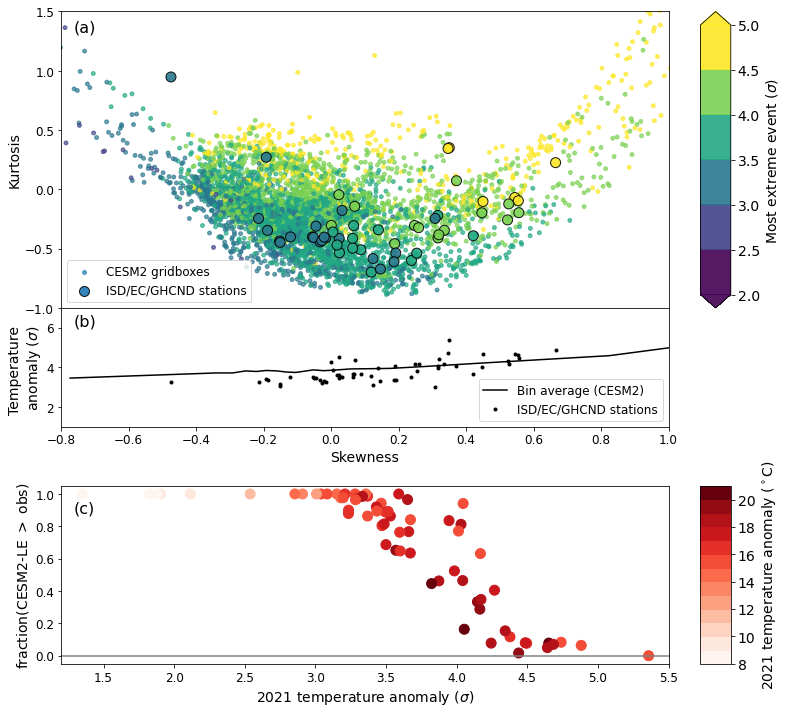

In [35]:
# Bin event magnitude by skewness and kurtosis for side plots
z = (cesm_ds['event_mag'].sel(qs=1)/cesm_ds['sigma']).values.flatten()

x = cesm_ds['skew'].values.flatten()
y = cesm_ds['kurtosis'].values.flatten()
has_data = ~np.isnan(x)
x = x[has_data]
y = y[has_data]
z = z[has_data]
x_bins = np.percentile(x, np.arange(0, 101, 5))
y_bins = np.percentile(y, np.arange(0, 101, 5))
bin_centers_x = 1/2*(x_bins[:-1] + x_bins[1:])
bin_centers_y = 1/2*(y_bins[:-1] + y_bins[1:])
z_binned_x = np.empty_like(bin_centers_x)
z_binned_y = np.empty_like(bin_centers_x)
for b in range(len(x_bins) - 1):
    idx = (x >= x_bins[b]) & (x < x_bins[b + 1])
    z_binned_x[b] = np.mean(z[idx])
    
    idx = (y >= y_bins[b]) & (y < y_bins[b + 1])
    z_binned_y[b] = np.mean(z[idx])
    

# Fraction of CESM gridboxes with greater anomalies than observed
# only use unique values to get frac_greater!
qs = ds_bootstrap.qs
n_unique = []
frac_greater = np.nan*np.empty((len(ds_bootstrap.station), len(qs)))
lats_hot = []
lons_hot = []
for station_ct, this_station in enumerate(ds_bootstrap.station):
    this_cesm = ds_bootstrap['cesm_event_mag'].sel(station=this_station)
    these_lats = ds_bootstrap['lat_cesm'].sel(station=this_station)
    these_lons = ds_bootstrap['lon_cesm'].sel(station=this_station)
    get_unique, unique_idx = np.unique(this_cesm, axis=0, return_index=True)
    n_unique.append(len(unique_idx))
    this_frac_greater = np.sum(get_unique > ds_eventmag_Txn['event_norm_TMAX'].sel(station=this_station).values, 
                               axis=0)
    frac_greater[station_ct, :] = this_frac_greater/len(unique_idx) # normalize by number of unique events
    # record the lat/lon of stations where the max exceeds the observed one
    # if hot at that station
    if ds_eventmag_Txn['event_norm_TMAX'].sel(station=this_station).values > 4:
        hotter_cesm = (get_unique[:, -1] > ds_eventmag_Txn['event_norm_TMAX'].sel(station=this_station).values)
        if np.sum(hotter_cesm) > 0:
            lats_hot.append(these_lats[unique_idx][hotter_cesm].values)
            lons_hot.append(these_lons[unique_idx][hotter_cesm].values)
        else:
            print('no hotter CESM temperatures!')
    
frac_greater = ds_bootstrap['cesm_event_mag'].sel(sample=0).copy(data=frac_greater)
lats_hot = np.hstack(lats_hot)
lons_hot = np.hstack(lons_hot)

n_unique = np.array(n_unique)
print(np.min(n_unique), np.median(n_unique), np.max(n_unique))

frac_greater = frac_greater.where(~np.isnan(ds_eventmag_Txn['event_norm_TMAX']))

# Make figure
fig = plt.figure(figsize=(12, 12))

widths = [10, 0.5]
heights = [10, 4, 2, 6]
spec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0)

cmap = plt.cm.viridis
bounds = np.arange(2, 5.1, 0.5)
norm = BoundaryNorm(bounds, cmap.N)

ax_main = fig.add_subplot(spec[0, 0])

# CESM2
sc = ax_main.scatter(cesm_ds['skew'].values.flatten(),
                cesm_ds['kurtosis'].values.flatten(),
                s=15,
                c=(cesm_ds['event_mag'].sel(qs=1)/cesm_ds['sigma']).values.flatten(), 
                cmap=cmap,
                norm=norm,
                alpha=0.7, label='CESM2 gridboxes')

is_2021_max = ds_eventmag_Txn.station[ds_eventmag_Txn['is_2021_max_TMAX']]

sc = ax_main.scatter(ds_S_Txn.sel(station=is_2021_max)['S_TMAX'], 
                     ds_K_Txn.sel(station=is_2021_max)['K_TMAX'], 
                     s=100, 
                     c=ds_eventmag_Txn.sel(station=is_2021_max)['event_norm_TMAX'], 
                     cmap=cmap,
                     norm=norm, alpha=0.9, edgecolor='k', label='ISD/EC/GHCND stations')
                
ax_main.legend(fontsize=12, loc='lower left')
ax_main.set_xlim(-0.8, 1)
ax_main.set_ylim(-1, 1.5)
                          
cax = fig.add_subplot(spec[0, 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=14) 
cb.set_label('Most extreme event ($\sigma$)', fontsize=14)

# Add average over skewness
ax_skew = fig.add_subplot(spec[1, 0])
ax_skew.plot(bin_centers_x, z_binned_x, 'k', label='Bin average (CESM2)')
ax_skew.plot(ds_S_Txn.sel(station=is_2021_max)['S_TMAX'].values.flatten(), 
             ds_eventmag_Txn.sel(station=is_2021_max)['event_norm_TMAX'], '.k',
             label='ISD/EC/GHCND stations')
ax_skew.legend(fontsize=12, loc='lower right')

ax_main.set_xlim(-0.8, 1)
ax_skew.set_xlim(-0.8, 1)
ax_skew.set_ylim(1, 7)
ax_main.set_ylim(-1, 1.5)
ax_main.set_xticks([])
ax_main.tick_params(labelsize=12)
ax_skew.tick_params(labelsize=12)
ax_skew.set_xlabel('Skewness', fontsize=14)
ax_skew.set_ylabel('Temperature \nanomaly ($\sigma$)', fontsize=14)
ax_main.set_ylabel('Kurtosis', fontsize=14)

# Add exceedances
cmap = plt.cm.Reds
bounds = np.arange(8, 22, 1)
norm = BoundaryNorm(bounds, cmap.N)

ax1 = plt.subplot(spec[-1, 0])
ax1.axhline(0, color='gray')

actual_T = ds_eventmag_Txn['event_norm_TMAX'].values*ds_sigma_Txn['sigma_TMAX'].values

sc = ax1.scatter(ds_eventmag_Txn['event_norm_TMAX'], 
                 frac_greater.sel(qs=1),
                 s=100, 
                 c=actual_T, 
                 marker='o', 
                 cmap=cmap, 
                 norm=norm, 
                 label='Stations')

ax1.set_xlabel('2021 temperature anomaly ($\sigma$)', fontsize=14)
ax1.set_ylabel('fraction(CESM2-LE $>$ obs)', fontsize=14)
#ax1.legend(fontsize=14)
ax1.tick_params(labelsize=12)
ax1.set_xlim(1.2, 5.5)
cax = fig.add_subplot(spec[-1, 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='neither')
cb.ax.tick_params(labelsize=14) 
cb.set_label('2021 temperature anomaly ($^\circ$C)', fontsize=14)

ax_main.text(0.02, 0.93, '(a)', fontsize=16, transform=ax_main.transAxes)
ax_skew.text(0.02, 0.85, '(b)', fontsize=16, transform=ax_skew.transAxes)
ax1.text(0.02, 0.85, '(c)', fontsize=16, transform=ax1.transAxes)

plt.savefig('%s/skew_kurt_and_exceedances_cesm2_%s.png' % (figdir, forcing), dpi=200, bbox_inches='tight')

# GEV-based predictions of very extreme events

In [59]:
# Fit GEV to the 71 years of data before the event
savename = '%s/prob_fitted_GEV_CESM2.nc' % procdir

if os.path.isfile(savename):
    ds_p_GEV = xr.open_dataset(savename)   
else:
    # Load CESM2 data to identify very extreme events
    files = sorted(glob('%s/cesm2_BHIST%s_%s_????-???.nc' % (cesm_dir, forcing, cesm_var)))
    files2 = [f.replace('BHIST', 'BSSP370') for f in files]

    da = xr.open_mfdataset(files, combine='nested', concat_dim='member', chunks={'time': -1})[cesm_var]

    new_time = pd.date_range(start='1850-06-15', end='2014-07-15', freq='D')
    new_time = new_time[(new_time.dayofyear >= doy_start) & (new_time.dayofyear <= doy_end)]
    da['time'] = new_time

    da2 = xr.open_mfdataset(files2, combine='nested', concat_dim='member', chunks={'time': -1})[cesm_var]

    new_time = pd.date_range(start='2015-06-15', end='2100-07-15', freq='D')
    new_time = new_time[(new_time.dayofyear >= doy_start) & (new_time.dayofyear <= doy_end)]
    da2['time'] = new_time

    da = xr.concat((da, da2), dim='time')
    del da2
    
    p_gev = np.empty((len(lats_hot)))
    shape_gev = np.empty((len(lats_hot)))
    ks_stat = np.empty((len(lats_hot)))
    ks_p = np.empty((len(lats_hot)))
    max_year_save = np.empty((len(lats_hot)))
    bad_shape = np.zeros((len(lats_hot)))

    for counter in range(len(lats_hot)):
        if counter % 10 == 0:
            print(counter)
        da_example = da.sel(lat=lats_hot[counter], lon=lons_hot[counter])
        # forced trend is assumed to be the ensemble mean
        da_example_anom = da_example - da_example.mean('member')
        da_example_anom_annmax = da_example_anom.groupby('time.year').max().load()

        max_member, max_year = np.unravel_index(da_example_anom_annmax.sel(year=slice('2020')).argmax(),
                                                da_example_anom_annmax.sel(year=slice('2020')).shape)

        da_use = da_example_anom_annmax.isel(member=max_member)
        max_year_save[counter] = max_year

        if max_year < 72:
            data_to_fit = da_use.sel(year=slice('2020'))[:72]
            hot_year = data_to_fit[max_year]
            data_to_fit = data_to_fit.where(data_to_fit.year != hot_year.year)
            data_to_fit = data_to_fit[~np.isnan(data_to_fit)]
        else:
            data_to_fit = da_use.sel(year=slice('%04i' % (da_use.year[max_year] - 1)))
            hot_year = da_use.isel(year=max_year)
            data_to_fit = data_to_fit[-71:]  # just get 71 years in advance

        # Current approach: for all of the gridboxes with big heat waves, how often does the GEV capture them
        # given 71 years of data?

        # Fit GEV to data_to_fit
        shape, loc, scale = gev.fit(data_to_fit)
        if shape > 1:
            print('*')
            bad_shape[counter] = 1
        
        # For a few stations, the fitted GEV has a crazy shape parameter that gives an unrealistic fit 
        # to the data, likely related to issues with the MLE fit. 
        # Resampling the data solves the problem.
        while shape > 1:
            shape, loc, scale = gev.fit(np.random.choice(data_to_fit, len(data_to_fit)))
        
        # Perform ks-test for fit
        out = kstest(data_to_fit, 'genextreme', args=(shape, loc, scale))
        ks_stat[counter] = out[0]
        ks_p[counter] = out[1]

        # estimate probability of event
        p_gev[counter] = gev.pdf(hot_year, shape, loc=loc, scale=scale)
        shape_gev[counter] = shape

    # Change sign of shape parameter to match standard approach
    ds_p_GEV = xr.Dataset(data_vars={'prob_GEV': (('lat'), p_gev), 
                                     'shape_GEV': (('lat'), -shape_gev),
                                     'ks_stat': (('lat'), ks_stat),
                                     'ks_pval': (('lat'), ks_p),
                                     'max_year': (('lat'), max_year_save),
                                     'bad_shape': (('lat'), bad_shape)},
                       coords={'lat': lats_hot,
                               'lon': lons_hot})

    ds_p_GEV.to_netcdf(savename)
    
# What fraction of p-values are larger than certain thresholds?
print('%i pvalues greater than 0.05' % (ds_p_GEV['ks_pval'] > 0.05).sum())
print('%i pvalues greater than 0.5' % (ds_p_GEV['ks_pval'] > 0.5).sum())

# What fraction of fits predict a probability of zero?
zero_prob_gev = np.sum(ds_p_GEV['prob_GEV'] == 0).values/len(ds_p_GEV['prob_GEV'])
print('%0.2f percent of fitted values predict p = 0' % (100*zero_prob_gev))

# Subset for correct shape parameter
subset_shape = ds_p_GEV.where((ds_p_GEV['shape_GEV'] < 0) & (ds_p_GEV['shape_GEV'] > -0.5))['prob_GEV']
zero_prob_gev = np.sum(subset_shape == 0).values/np.sum(~np.isnan(subset_shape))
print('%0.2f percent of fitted values predict p = 0' % (100*zero_prob_gev))

low_prob_gev = (ds_p_GEV['prob_GEV'] < 1/8550).sum()/len(ds_p_GEV['prob_GEV'])
print('%0.2f percent of fitted values predict p < 1/8550' % (100*low_prob_gev))
    



350 pvalues greater than 0.05
315 pvalues greater than 0.5
63.82 percent of fitted values predict p = 0
63.83 percent of fitted values predict p = 0
77.49 percent of fitted values predict p < 1/8550


# Calculate quantile regression trends in observations

If nboot is large, this can be slow!

In [53]:
qs_to_fit = np.array([0.5, 0.95, 0.99])
nboot = 500  # number of times to bootstrap to get uncertainty estimates in trends
# Control for FDR 
alpha_fdr = 0.1

qr_savename = '%s/qr_station_data_%s.nc' % (procdir, variable_to_use)
if os.path.isfile(qr_savename):
    ds_QR = xr.open_dataset(qr_savename)
else:
    # Fit QR trends to each dataset
    ds_QR_GHCND = heat_utils.fit_qr_trend(ds_ghcnd[variable_to_use], doy_start, doy_end, qs_to_fit, nboot)
    ds_QR_GHCND.to_netcdf('%s/qr_ghcnd_%s.nc' % (savedir, variable_to_use))
    
    ds_QR_ISD = heat_utils.fit_qr_trend(ds_isd[variable_to_use], doy_start, doy_end, qs_to_fit, nboot)
    ds_QR_ISD.to_netcdf('%s/qr_isd_%s.nc' % (savedir, variable_to_use))
    
    ds_QR_EC = heat_utils.fit_qr_trend(ds_ec[variable_to_use], doy_start, doy_end, qs_to_fit, nboot)
    ds_QR_EC.to_netcdf('%s/qr_ec_%s.nc' % (savedir, variable_to_use))
    ds_QR = xr.merge((ds_QR_GHCND, ds_QR_ISD, ds_QR_EC))
    
    ds_QR.to_netcdf(qr_savename)

# Significance of difference in signs: 
# Calculate the fraction of bootstrapped samples of the opposite  
delta_95_50 = ds_QR['beta_QR_boot'].sel(qs=0.95) - ds_QR['beta_QR_boot'].sel(qs=0.5)
delta_99_50 = ds_QR['beta_QR_boot'].sel(qs=0.99) - ds_QR['beta_QR_boot'].sel(qs=0.5)

is_missing = np.isnan(delta_95_50).all(axis=-1)
delta_95_50 = delta_95_50[~is_missing]
delta_99_50 = delta_99_50[~is_missing]
a = np.arange(delta_95_50.shape[0]) + 1

# Count the number of bootstrapped values on either side of zero
counts = np.vstack((np.sum(delta_95_50 < 0, axis=-1), np.sum(delta_95_50 > 0, axis=-1)))
# Consider the pvalue as the fraction of counts on the other side from the bulk of the samples
pval_95_50 = np.min(counts, axis=0)/nboot
try:
    cutoff_idx = np.where(np.sort(pval_95_50) <= alpha_fdr*a/len(a))[0][-1]
    cutoff_p_95_50 = np.sort(pval_95_50)[cutoff_idx]
except IndexError:
    cutoff_p_95_50 = 0

# Same for 99-50
counts = np.vstack((np.sum(delta_99_50 < 0, axis=-1), np.sum(delta_99_50 > 0, axis=-1)))
pval_99_50 = np.min(counts, axis=0)/nboot
try:
    cutoff_idx = np.where(np.sort(pval_99_50) <= alpha_fdr*a/len(a))[0][-1]
    cutoff_p_99_50 = np.sort(pval_99_50)[cutoff_idx]
except IndexError:
    cutoff_p_99_50 = 0

# Also calculate pvalue cutoff for QR trends themselves
a = np.arange(len(ds_QR.station)) + 1
cutoff_idx = np.where(np.sort(ds_QR['pval_QR'].sel(qs=0.50)) <= alpha_fdr*a/len(a))[0][-1]
cutoff_p_50 = np.sort(ds_QR['pval_QR'].sel(qs=0.50))[cutoff_idx]

cutoff_idx = np.where(np.sort(ds_QR['pval_QR'].sel(qs=0.95)) <= alpha_fdr*a/len(a))[0][-1]
cutoff_p_95 = np.sort(ds_QR['pval_QR'].sel(qs=0.95))[cutoff_idx]

cutoff_idx = np.where(np.sort(ds_QR['pval_QR'].sel(qs=0.99)) <= alpha_fdr*a/len(a))[0][-1]
cutoff_p_99 = np.sort(ds_QR['pval_QR'].sel(qs=0.99))[cutoff_idx]

delta_alldata = (ds_QR['beta_QR'].sel(qs=0.95) - ds_QR['beta_QR'].sel(qs=0.5))[~is_missing]
print('%i stations (out of %i) have 95th percentile trend greater than 50th' %
      (np.sum(delta_alldata > 0), len(delta_alldata)))


43 stations (out of 69) have 95th percentile trend greater than 50th


# Count exceedances of different thresholds in locations that match the S/K of PNW stations

In [43]:
all_locs = np.dstack((ds_bootstrap['lat_cesm'].values, ds_bootstrap['lon_cesm'].values))
d1, d2, d3 = all_locs.shape
all_locs = all_locs.reshape((d1*d2, d3))
all_locs_unique = np.unique(all_locs, axis=0)

nlat, nlon, _, _ = cesm_ds['count_event'].shape
mask_match = np.zeros((nlat, nlon))
lons_grid, lats_grid = np.meshgrid(cesm_ds.lon, cesm_ds.lat)

for ct in range(len(all_locs_unique)):
    idx_lat = np.where(all_locs_unique[ct, 0] == cesm_ds.lat)[0][0]
    idx_lon = np.where(all_locs_unique[ct, 1] == cesm_ds.lon)[0][0]
    mask_match[idx_lat, idx_lon] = 1

da_mask_match = xr.DataArray(mask_match, 
                             dims=('lat', 'lon'), 
                             coords={'lat': cesm_ds.lat, 'lon': cesm_ds.lon})

count_match = cesm_ds['count_event'].where(da_mask_match)

weights = np.sqrt(np.cos(np.deg2rad(count_match.lat)))
count_match_avg = count_match.weighted(weights).mean(['lat','lon'])
count_match_avg /= 50  # originally added up events across members

print('Probability of exceeding 99.9th percentile: %0.4f' % 
      count_match_avg.sel(qs=0.999).sel(year=slice(2020, 2050)).mean())
print('Probability of exceeding historical max: %0.4f' % 
      count_match_avg.sel(qs=1).sel(year=slice(2020, 2050)).mean())

Probability of exceeding 99.9th percentile: 0.0013
Probability of exceeding historical max: 0.0001


# Figure 3: QR trends and model-based exceedances

In [ ]:
# PANELS A-C
fig = plt.figure(figsize=(18, 8))
widths = [1, 1, 1, 0.1]
spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=widths)

spec.update(wspace=0.1, hspace=0.1)

datacrs = ccrs.PlateCarree()
extent = [235, 247, 42, 60]
plotcrs = ccrs.PlateCarree(central_longitude=np.mean(extent[:2]))

extend_cf = 'both'

ghcnd_size = 200

# QR50
bounds = np.arange(-4, 5, 1)
cmap = plt.cm.RdBu_r
ax0 = fig.add_subplot(spec[0], projection=plotcrs)

is_sig = ds_QR['pval_QR'].sel(qs=0.5) <= cutoff_p_50
cf, cp, sc = heat_utils.plot_PWN(ax0, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, None, 
             ds_QR.lon[~is_sig], ds_QR.lat[~is_sig], ds_QR['beta_QR'].sel(qs=0.5)[~is_sig], 
                      int(ghcnd_size*0.75), bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='p', title_size=fontsize)

cf, cp, sc = heat_utils.plot_PWN(ax0, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, None, 
             ds_QR.lon[is_sig], ds_QR.lat[is_sig], ds_QR['beta_QR'].sel(qs=0.5)[is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='o', title_size=fontsize)

# QR 95
ax1 = fig.add_subplot(spec[1], projection=plotcrs)
is_sig = ds_QR['pval_QR'].sel(qs=0.95) <= cutoff_p_95
cf, cp, sc = heat_utils.plot_PWN(ax1, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, np.arange(0, 2), 
             ds_QR.lon[~is_sig], ds_QR.lat[~is_sig], ds_QR['beta_QR'].sel(qs=0.95)[~is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='p', title_size=fontsize)

cf, cp, sc = heat_utils.plot_PWN(ax1, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, np.arange(0, 2), 
             ds_QR.lon[is_sig], ds_QR.lat[is_sig], ds_QR['beta_QR'].sel(qs=0.95)[is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', maker='s', title_size=fontsize)

# QR 95 - QR 50
ax2 = fig.add_subplot(spec[2], projection=plotcrs)
is_sig = pval_95_50 <= cutoff_p_95_50
cf, cp, sc = heat_utils.plot_PWN(ax2, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, np.arange(0, 2), 
             ds_QR.lon[~is_missing][~is_sig], ds_QR.lat[~is_missing][~is_sig], 
                      (ds_QR['beta_QR'].sel(qs=0.95) - ds_QR['beta_QR'].sel(qs=0.5))[~is_missing][~is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='p', title_size=fontsize)

cf, cp, sc = heat_utils.plot_PWN(ax2, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, np.arange(0, 2), 
             ds_QR.lon[~is_missing][is_sig], ds_QR.lat[~is_missing][is_sig], 
                      (ds_QR['beta_QR'].sel(qs=0.95) - ds_QR['beta_QR'].sel(qs=0.5))[~is_missing][is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', maker='s', title_size=fontsize)

# Colorbar
cax = fig.add_subplot(spec[3])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=fontsize) 
cb.set_label(r'Quantile trend or difference in trends ($^\circ$C/$^\circ$C)', fontsize=fontsize)

ax0.text(0.03, 0.94, '(a)', fontsize=fontsize, transform=ax0.transAxes)
ax1.text(0.03, 0.94, '(b)', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(0.03, 0.94, '(c)', fontsize=fontsize, transform=ax2.transAxes)
plt.savefig('%s/qr_trends_stations_95_50.png' % figdir, dpi=200, bbox_inches='tight')

# PANEL D
fig, ax = plt.subplots(figsize=(15, 5))

count_match_avg.sel(qs=0.999).plot.line(x='year', label=r'$>$99.9th percentile')

# Plot rolling average
count_match_avg.sel(qs=0.999).rolling(year=11, 
                                    center=True).mean().plot.line(x='year',
                                                                  color='k',
                                                                  label=r'$>$99.9th percentile (11yr mean)')

count_match_avg.sel(qs=1).plot.line(x='year', color='tab:red', label=r'> historical maximum')
ax.axvline(2020, color='gray')

ax.tick_params(labelsize=12)
# ax.legend(fontsize=14, loc='upper left')
ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(0.05, 0.97), borderaxespad=0)

ax.set_title('')
ax.set_xlabel('')
ax.text(0.01, 0.93, '(d)', fontsize=fontsize, transform=ax.transAxes)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_ylabel('Average event probability', fontsize=14)
plt.savefig('%s/p_event_trend_cesm2_%s.png' % (figdir, forcing), dpi=200, bbox_inches='tight')

# Figure S1: seasonal cycle

Note that the seasonal cycle is based on a raw average (no attempt to weight stations) and is primarily for illustrative purposes.

In [ ]:
# Not performing weighting
seasonal_cycle_GHCND = (ds_ghcnd_fitted).groupby('time.dayofyear').mean()
seasonal_cycle_EC = (ds_ec_fitted).groupby('time.dayofyear').mean()
seasonal_cycle_ISD = (ds_isd_fitted).groupby('time.dayofyear').mean()

seasonal_cycle_avg = xr.concat((seasonal_cycle_GHCND['%s_fit' % variable_to_use], 
                                seasonal_cycle_EC['%s_fit' % variable_to_use], 
                                seasonal_cycle_ISD['%s_fit' % variable_to_use]), 
                               dim='dataset')

fig, ax = plt.subplots(figsize=(10, 5))

seasonal_cycle_GHCND['%s_fit' % variable_to_use].mean('station').plot(ax=ax, label='GHCND Tx', color='tab:green')
seasonal_cycle_EC['%s_fit' % variable_to_use].mean('station').plot(ax=ax, label='EC Tx', color='tab:blue')
seasonal_cycle_ISD['%s_fit' % variable_to_use].mean('station').plot(ax=ax, label='ISD Tx', color='tab:purple')
seasonal_cycle_avg.mean(['station', 'dataset']).plot(ax=ax, label='Dataset avg Tx', color='k')

ax.axvline(doy_start, color='gray', label='June 15-July 15')
ax.axvline(doy_end, color='gray')
ax.legend(fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xlabel('Day of year', fontsize=14)
ax.set_ylabel('Temperature (degC)', fontsize=14)

plt.savefig('%s/seasonal_cycle_stations.png' % figdir, dpi=200, bbox_inches='tight')

# Figure S2: standard deviation and autocorrelation across stations

Also indicate data source of each station

EC: square
ISD: triangle
GHCND: diamond


/opt/miniconda3/envs/stats/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


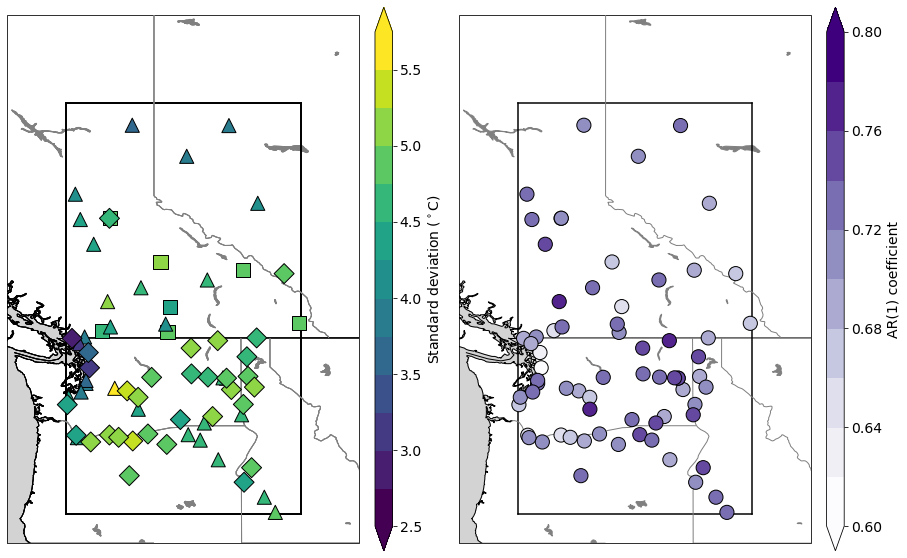

In [52]:
# For supplement, plot standard deviation and autocorrelation coefficient

fig = plt.figure(figsize=(15, 10))
widths = [1, 0.05, 0.1, 1, 0.05]
spec = fig.add_gridspec(ncols=5, nrows=1, width_ratios=widths)

spec.update(wspace=0.1, hspace=0.1)

datacrs = ccrs.PlateCarree()
extent = [235, 247, 42, 60]
plotcrs = ccrs.PlateCarree(central_longitude=np.mean(extent[:2]))

extend_cf = 'both'

ghcnd_size = 200

# Standard deviation
# Plot a different marker for each dataset
bounds = np.arange(2.5, 6, 0.25)
cmap = plt.cm.viridis
ax0 = fig.add_subplot(spec[0], projection=plotcrs)


cf, cp, sc = heat_utils.plot_PWN(ax0, extent, plotcrs, datacrs, cmap, 
                                 None, bounds, extend_cf, False, None, np.arange(0, 2), 
                                 ds_sigma_EC.lon, ds_sigma_EC.lat, 
                                 ds_sigma_EC['sigma_%s' % variable_to_use], ghcnd_size, bounds,
                                 lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='s', title_size=fontsize)

cf, cp, sc = heat_utils.plot_PWN(ax0, extent, plotcrs, datacrs, cmap, 
                                 None, bounds, extend_cf, False, None, np.arange(0, 2), 
                                 ds_sigma_ISD.lon, ds_sigma_ISD.lat, 
                                 ds_sigma_ISD['sigma_%s' % variable_to_use], ghcnd_size, bounds,
                                 lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='^', title_size=fontsize)

cf, cp, sc = heat_utils.plot_PWN(ax0, extent, plotcrs, datacrs, cmap, 
                                 None, bounds, extend_cf, False, None, np.arange(0, 2), 
                                 ds_sigma_GHCND.lon, ds_sigma_GHCND.lat, 
                                 ds_sigma_GHCND['sigma_%s' % variable_to_use], ghcnd_size, bounds,
                                 lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='D', title_size=fontsize)

print('EC: square')
print('ISD: triangle')
print('GHCND: diamond')

# Add colorbar (same for all plots)
cax = fig.add_subplot(spec[1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=14) 
cb.set_label('Standard deviation ($^\circ$C)', fontsize=14)

# AR(1) coeff
bounds = np.arange(0.6, 0.81, 0.02)
cmap = plt.cm.Purples
ax1 = fig.add_subplot(spec[3], projection=plotcrs)
cf, cp, sc = heat_utils.plot_PWN(ax1, extent, plotcrs, datacrs, cmap, 
                                 None, bounds, extend_cf, False, None, np.arange(0, 2), 
                                 ds_rho1_Txn.lon, ds_rho1_Txn.lat, 
                                 ds_rho1_Txn['rho1_%s' % variable_to_use], ghcnd_size, bounds,
                                 lats_box=lats_PNW, lons_box=lons_PNW, title='', title_size=fontsize)

# Add colorbar (same for all plots)
cax = fig.add_subplot(spec[-1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=14) 
cb.set_label('AR(1) coefficient', fontsize=14)

plt.savefig('%s/sigma_AR1_stations.png' % figdir, dpi=200, bbox_inches='tight')

# Figure S3: Explanatory figure for skewness/kurtosis uncertainty at a single station

CA001090660


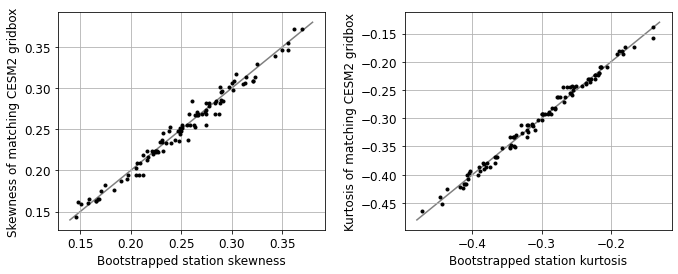

In [34]:
fig, ax = plt.subplots(figsize=(11, 4), ncols=2)
plt.subplots_adjust(wspace=0.3)

station_plot = 0
print(ds_bootstrap.isel(station=station_plot).station.values)
ax[0].plot(ds_bootstrap['skew_station'].isel(station=station_plot), 
           ds_bootstrap['skew_cesm'].isel(station=station_plot), '.k')
ax[1].plot(ds_bootstrap['kurtosis_station'].isel(station=station_plot), 
           ds_bootstrap['kurtosis_cesm'].isel(station=station_plot), '.k')

ax[0].plot([0.14, 0.38], [0.14, 0.38], color='gray', zorder=0)
ax[1].plot([-0.48, -0.13], [-0.48, -0.13], color='gray', zorder=0)

ax[0].set_xlabel('Bootstrapped station skewness', fontsize=12)
ax[0].set_ylabel('Skewness of matching CESM2 gridbox', fontsize=12)

ax[1].set_xlabel('Bootstrapped station kurtosis', fontsize=12)
ax[1].set_ylabel('Kurtosis of matching CESM2 gridbox', fontsize=12)

for a in ax:
    a.tick_params(labelsize=12)
    a.grid()
    
plt.savefig('%s/example_S_K_bootstrap_cesm2_%s.png' % (figdir, forcing), dpi=200, bbox_inches='tight')


# Figure S4: "matching" locations in CESM2

In [36]:
fig = plt.figure(figsize=(20, 5))
widths = [10, 0.4]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

spec.update(wspace=0.1, hspace=0.1)

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
extent = [-179, 180, 35, 75]
plotcrs = ccrs.PlateCarree(central_longitude=(extent[0] + extent[1])/2)

ax_map = fig.add_subplot(spec[0, 0], projection=plotcrs)

ax_map.set_extent(extent)

cmap = plt.cm.Reds
bounds = np.arange(0, 21)
norm = colors.BoundaryNorm(bounds, cmap.N)


sc = ax_map.scatter(all_locs_unique[:, -1],
                    all_locs_unique[:, 0],
                    transform=datacrs,
                    zorder=3, color='k', s=3)

# add points where CESM was hotter than 3.5sigma
ax_map.scatter(lons_hot, lats_hot,
                transform=datacrs,
                zorder=3, color='tab:red', s=3)
    
ax_map.plot([-180, 180], [40, 40], zorder=10, color='tab:blue')
ax_map.plot([-180, 180], [70, 70], zorder=10, color='tab:blue')


states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax_map.add_feature(cfeature.OCEAN, color='lightgray', zorder=2)
ax_map.add_feature(cfeature.LAKES, color='gray', zorder=2)
ax_map.add_feature(cfeature.COASTLINE, color='black', zorder=2)
ax_map.add_feature(cfeature.BORDERS, color='black', zorder=2)
ax_map.add_feature(states_provinces, edgecolor='gray', zorder=2)

plt.savefig('%s/map_CESM2_%s_like_stations.png' % (figdir, forcing), dpi=200, bbox_inches='tight')


# Figure S5: GEV example

In [ ]:
counter = 171  # associated with gridbox in Oregon
print(lats_hot[counter], lons_hot[counter])

# Need to load data to pull out relevant gridbox
files = sorted(glob('%s/cesm2_BHIST%s_%s_????-???.nc' % (cesm_dir, forcing, cesm_var)))
files2 = [f.replace('BHIST', 'BSSP370') for f in files]

da = xr.open_mfdataset(files, combine='nested', concat_dim='member', chunks={'time': -1})[cesm_var]

new_time = pd.date_range(start='1850-06-15', end='2014-07-15', freq='D')
new_time = new_time[(new_time.dayofyear >= doy_start) & (new_time.dayofyear <= doy_end)]
da['time'] = new_time

da2 = xr.open_mfdataset(files2, combine='nested', concat_dim='member', chunks={'time': -1})[cesm_var]

new_time = pd.date_range(start='2015-06-15', end='2100-07-15', freq='D')
new_time = new_time[(new_time.dayofyear >= doy_start) & (new_time.dayofyear <= doy_end)]
da2['time'] = new_time

da = xr.concat((da, da2), dim='time')
del da2

da_example = da.sel(lat=lats_hot[counter], lon=lons_hot[counter])
# remove ensemble mean: average each year
EM = da_example.mean('member').groupby('time.year').mean()

da_example_anom = da_example.groupby('time.year') - EM
da_example_anom_annmax = da_example_anom.groupby('time.year').max().load()

max_member, max_year = np.unravel_index(da_example_anom_annmax.sel(year=slice('2020')).argmax(),
                                        da_example_anom_annmax.sel(year=slice('2020')).shape)

da_use_anoms = da_example_anom_annmax.isel(member=max_member)
da_use_full = da_example.groupby('time.year').max().isel(member=max_member)

fig, ax = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)
(da_use_full - 273.15).plot(ax=ax[0], color='k')
ax[0].plot(da_use_full.year[max_year], da_use_full[max_year] - 273.15, 'ro')
da_use_anoms.plot(ax=ax[1], color='k')
ax[1].plot(da_use_anoms.year[max_year], da_use_anoms[max_year], 'ro')

# show GEV percentile fits
data_to_fit = da_use_anoms.sel(year=slice('%04i' % (da_use_anoms.year[max_year] - 1)))
data_to_fit = data_to_fit[-71:]
shape, loc, scale = gev.fit(data_to_fit)

qs_to_plot = np.array([0.5, 0.9, 0.99, 1])
for q in qs_to_plot:
    dist_val = gev.ppf(q, shape, loc, scale)
    ax[1].hlines(dist_val, data_to_fit.year[0], data_to_fit.year[-1], color='gray')

for a in ax:
    a.set_title('')
    a.set_xlabel('')
    a.tick_params(labelsize=fontsize)
    
ax[0].set_ylabel('Seasonal maxima \ntemperature ($^\circ$C)', fontsize=fontsize)
ax[1].set_ylabel('Seasonal maxima \ntemperature anomalies ($^\circ$C)', fontsize=fontsize)

ax[0].text(0.01, 0.92, '(a)', fontsize=fontsize, transform=ax[0].transAxes)
ax[1].text(0.01, 0.92, '(b)', fontsize=fontsize, transform=ax[1].transAxes)

plt.savefig('%s/GEV_example_Oregon.png' % figdir)

# Figure S6: Results for trends in the 99th percentile

/opt/miniconda3/envs/stats/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


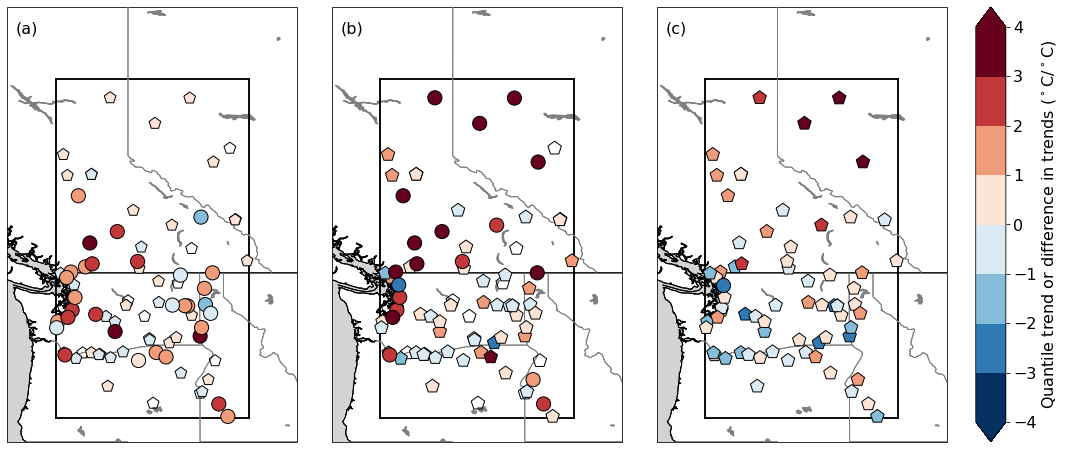

In [55]:
fig = plt.figure(figsize=(18, 8))
widths = [1, 1, 1, 0.1]
spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=widths)

spec.update(wspace=0.1, hspace=0.1)

datacrs = ccrs.PlateCarree()
extent = [235, 247, 42, 60]
plotcrs = ccrs.PlateCarree(central_longitude=np.mean(extent[:2]))

extend_cf = 'both'

ghcnd_size = 200

# QR50
bounds = np.arange(-4, 5, 1)
cmap = plt.cm.RdBu_r
ax0 = fig.add_subplot(spec[0], projection=plotcrs)

is_sig = ds_QR['pval_QR'].sel(qs=0.5) <= cutoff_p_50
cf, cp, sc = heat_utils.plot_PWN(ax0, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, None, 
             ds_QR.lon[~is_sig], ds_QR.lat[~is_sig], ds_QR['beta_QR'].sel(qs=0.5)[~is_sig], 
                      int(ghcnd_size*0.75), bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='p', title_size=fontsize)

cf, cp, sc = heat_utils.plot_PWN(ax0, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, None, 
             ds_QR.lon[is_sig], ds_QR.lat[is_sig], ds_QR['beta_QR'].sel(qs=0.5)[is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='o', title_size=fontsize)

# QR 99
ax1 = fig.add_subplot(spec[1], projection=plotcrs)
is_sig = ds_QR['pval_QR'].sel(qs=0.99) <= cutoff_p_99
cf, cp, sc = heat_utils.plot_PWN(ax1, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, np.arange(0, 2), 
             ds_QR.lon[~is_sig], ds_QR.lat[~is_sig], ds_QR['beta_QR'].sel(qs=0.99)[~is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='p', title_size=fontsize)

cf, cp, sc = heat_utils.plot_PWN(ax1, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, np.arange(0, 2), 
             ds_QR.lon[is_sig], ds_QR.lat[is_sig], ds_QR['beta_QR'].sel(qs=0.99)[is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', maker='s', title_size=fontsize)

# QR 95 - QR 50
ax2 = fig.add_subplot(spec[2], projection=plotcrs)
is_sig = pval_99_50 <= cutoff_p_99_50
cf, cp, sc = heat_utils.plot_PWN(ax2, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, np.arange(0, 2), 
             ds_QR.lon[~is_missing][~is_sig], ds_QR.lat[~is_missing][~is_sig], 
                      (ds_QR['beta_QR'].sel(qs=0.99) - ds_QR['beta_QR'].sel(qs=0.5))[~is_missing][~is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', marker='p', title_size=fontsize)

cf, cp, sc = heat_utils.plot_PWN(ax2, extent, plotcrs, datacrs, cmap, 
             None, bounds, extend_cf, False, None, np.arange(0, 2), 
             ds_QR.lon[~is_missing][is_sig], ds_QR.lat[~is_missing][is_sig], 
                      (ds_QR['beta_QR'].sel(qs=0.99) - ds_QR['beta_QR'].sel(qs=0.5))[~is_missing][is_sig], 
                      ghcnd_size, bounds,
             lats_box=lats_PNW, lons_box=lons_PNW, title='', maker='s', title_size=fontsize)

# Colorbar
cax = fig.add_subplot(spec[3])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=fontsize) 
cb.set_label(r'Quantile trend or difference in trends ($^\circ$C/$^\circ$C)', fontsize=fontsize)

ax0.text(0.03, 0.94, '(a)', fontsize=fontsize, transform=ax0.transAxes)
ax1.text(0.03, 0.94, '(b)', fontsize=fontsize, transform=ax1.transAxes)
ax2.text(0.03, 0.94, '(c)', fontsize=fontsize, transform=ax2.transAxes)


plt.savefig('%s/qr_trends_stations_99_50.png' % figdir, dpi=200, bbox_inches='tight')

# Figure S7: Trends and significance for different quantiles

Quantile trends with sig slopes:
[0.99  0.999 1.   ]


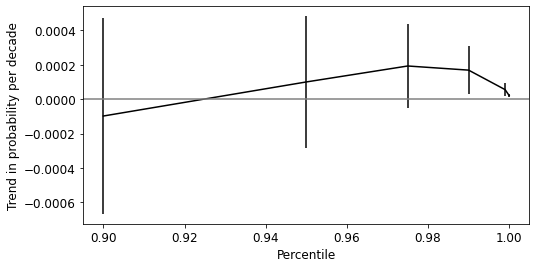

In [51]:
# Estimate trend from 2000-2100 for different quantiles
pvals = np.empty((len(count_match_avg.qs)))
slope = np.empty((len(count_match_avg.qs)))
slope_95 = np.empty((len(count_match_avg.qs)))
for ct_q, q in enumerate(count_match_avg.qs):
    this_count = count_match_avg.sel(qs=q)
    this_ts = this_count.sel(year=slice('2000', '2100'))
    out = stats.linregress(x=np.arange(len(this_ts)), y=this_ts.values)

    pvals[ct_q] = out.pvalue
    slope[ct_q] = 10*(out.slope)
    slope_95[ct_q] = 10*(1.959964*out.stderr)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(count_match_avg.qs, slope, color='k')
ax.vlines(count_match_avg.qs, slope - slope_95, slope + slope_95, color='k')
ax.axhline(0, color='gray')
ax.set_ylabel('Trend in probability per decade', fontsize=12)
ax.set_xlabel('Percentile', fontsize=12)
ax.tick_params(labelsize=12)
plt.savefig('%s/trend_2000_2100_count_cesm2_%s.png' % (figdir, forcing), dpi=200, bbox_inches='tight')

# check fdr control
alpha_fdr = 0.1
a = np.arange(len(pvals)) + 1
cutoff_idx = np.where(np.sort(pvals) <= alpha_fdr*a/len(a))[0][-1]
cutoff_extreme_prob = np.sort(pvals)[cutoff_idx]
is_sig = pvals <= cutoff_extreme_prob
print('Quantile trends with sig slopes:' )
print(count_match_avg.qs[is_sig].values)